# Purpose and Objectives:

You have probably just arrived from getting a thorough understanding of the architectures and capabilities of Autoencoders and Variational Autoencoders! Now, we will look at something more state-of-the-art, the **VQ-VAE** model.

After completing this notebook, you will:
1. Have a thorough understanding of the architecture and capabilites of the VQ-VAE
2. Be able to implement the VQ-VAE to reconstruct CIFAR-10 images
3. Evaluate the models' performance and explore a plethora of visualizations and ablations

## Motivation for VQ-VAE

Recall, that we motivated the VAE architecture by saying that we would like to regularize the latent space of the AE. We modeled the latent space as being sampled from a Gaussian distribution. This is a convenient and useful interpretation, but can we do better? Yes!

![coco_instance_segmentation.jpeg](https://github.com/chancharikmitra/CS182_All_About_Autoencoders/blob/main/demo/coco_instance_segmentation.jpeg?raw=1)

<p style="text-align: center;">Fig 1. An image taken from the COCO dataset </p>

[Source](https://manipulation.csail.mit.edu/segmentation.html)

The above image, taken from the COCO dataset, illustrates a very important facet of much of the data that is of interest to the deep learning community. Whether it is language, scene images, or audio files, many semantically meaningful data have *discrete elements within them.*

Thus, a logical new improvement to our VAE bottleneck would be to **sample from a discrete distribution instead of a continuous one**. That is precisely the main motivation for the VQ-VAE artchitecture.

### Concept Check 3-3.1

In [1]:
import random
import math

import numpy as np

import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.distributions import MultivariateNormal, Normal, Independent
from torchvision.utils import make_grid

from tqdm import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
#Reproducability Checks:
random.seed(0) #Python
torch.manual_seed(0) #Torch
np.random.seed(0) #NumPy

## Implementing VQ-VAE

### Residual Layers For Image Processing
We use ResNet blocks for image processing

In [4]:
class ResidualLayerBlock(nn.Module):
    def __init__(self, in_dim, h_dim, res_h_dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channels=in_dim, out_channels = res_h_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(res_h_dim),
            nn.ReLU(),
            nn.Conv2d(in_channels=res_h_dim, out_channels=h_dim, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(h_dim)
        )

    def forward(self, x):
        out = x + self.block(x)
        return out

In [5]:
class ResidualLayers(nn.Module):
    def __init__(self, in_dim, h_dim, res_h_dim, n_res_layers):
        super().__init__()
        self.n_res_layers = n_res_layers
        self.layers = nn.ModuleList(
            [ResidualLayerBlock(in_dim, h_dim, res_h_dim)] * n_res_layers
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return F.relu(x)

## Encoder

In [6]:
class Encoder(nn.Module):
    def __init__(self, in_dim, h_dim, res_h_dim, n_res_layers):
        super().__init__()
        kernel = 4
        stride = 2
        #Maybe remove batch norms?
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_dim, h_dim // 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(h_dim // 2),
            nn.ReLU(),
            nn.Conv2d(h_dim // 2, h_dim, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(h_dim),
            nn.ReLU(),
            nn.Conv2d(h_dim, h_dim, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(h_dim),
            ResidualLayers(h_dim, h_dim, res_h_dim, n_res_layers)
        ) 

    def forward(self, x):
      return self.conv_block(x)

## [Important] Vector Quantizer:

Recall that loss is defined as:

$$Recon(x, \hat{x}) + ||sg(z_e(x)) - e||_2^2 + \beta ||z_e(x) - e||_2^2$$

Where the first term is our codebook loss to keep our codebook close to our encoder outputs, and the third term is keep our codebook committed to a discrete distribution. Note that we are going to be quantizing over each individual channel pixel, so we we sample a channel from the discrete distribution. If the original image size is say for example $[64, 3, 32, 32]$, we first rearrange it to have each element be a channel pixel, i.e $[64, 32, 32, 3]$, then flatten it to get each individuala channel yielding $[64 * 32 * 32, 3]$. Now we have $64 * 32 * 32$ seperate channel pixels to query from the latent distribution, and map them to its closest latent distribution value. It should be noted that the outputs from the gradient wont have any actual gradients, because of the nearest neighbor sampling. To deal with this, we copy the gradient from the outputs to the inputs. In other words, we do:

$$e := z_e(x) + sg(e - z_e(x))$$

This allows the gradients of $e$ to be copied over to $z_e(x)$ and backprop to our encoder. In this problem, you will code the the vector quantitization modules to sample the latent space

### Concept Check 3.2.1-3.2.3

In [7]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1) 
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach() #allows for copied gradients
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

## The Decoder Class

Uses the sampled discrete distribution and reconstruct the image.

In [8]:
class Decoder(nn.Module):
    def __init__(self, in_dim, h_dim, n_res_layers, res_h_dim):
        super(Decoder, self).__init__()
        kernel = 4
        stride = 2

        self.inverse_conv_stack = nn.Sequential(
            nn.ConvTranspose2d(
                in_dim, h_dim, kernel_size=kernel-1, stride=stride-1, padding=1),
            ResidualLayers(h_dim, h_dim, res_h_dim, n_res_layers),
            nn.ConvTranspose2d(h_dim, h_dim // 2,
                               kernel_size=kernel, stride=stride, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(h_dim//2, 3, kernel_size=kernel,
                               stride=stride, padding=1)
        )

    def forward(self, x):
        return self.inverse_conv_stack(x)

## The VQAE Module

This is the main module for the VQ-VAE. The model consists of 

$$Encoder \to VectorQuantitization \to Decoder \to \hat{x}$$

Each image will have its own discrete mapping. Let $f_{vq}(x)$ be the discrete mapping from an image $x$ to its discrete mapping. Once the model is trained, we will have good mappings for $x \to f_{vq}(x)$. However, to actually sample from the VQ-VAE, we need to learn patterns from the learned $f_{vq}(x)$. Once we can sample $f_{vq}$ perhaps using PixelCNN, we can send it into the decoder.

In [9]:
class VQVAE(nn.Module):
    def __init__(self, h_dim, res_h_dim, n_res_layers,
                 n_embeddings, embedding_dim, beta, save_img_embedding_map=False):
        super(VQVAE, self).__init__()
        # encode image into continuous latent space
        self.encoder = Encoder(3, h_dim, n_res_layers, res_h_dim)
        self.pre_quantization_conv = nn.Conv2d(
            h_dim, embedding_dim, kernel_size=1, stride=1)
        # pass continuous latent vector through discretization bottleneck
        self.vector_quantization = VectorQuantizer(
            n_embeddings, embedding_dim, beta)
        # decode the discrete latent representation
        self.decoder = Decoder(embedding_dim, h_dim, n_res_layers, res_h_dim)

        if save_img_embedding_map:
            self.img_to_embedding_map = {i: [] for i in range(n_embeddings)}
        else:
            self.img_to_embedding_map = None

    def forward(self, x, verbose=False):

        z_e = self.encoder(x)

        z_e = self.pre_quantization_conv(z_e)
        embedding_loss, z_q, perplexity, _ = self.vector_quantization(z_e)
        x_hat = self.decoder(z_q)

        return embedding_loss, x_hat, perplexity

**Downloading and normalizing the CIFAR 10 Dataset**

In [10]:
training_data = torchvision.datasets.CIFAR10(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

validation_data = torchvision.datasets.CIFAR10(root="data", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))
data_variance = np.var(training_data.data / 255.0)
data_variance

100%|██████████| 170498071/170498071 [00:05<00:00, 29782475.18it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


0.06328692405746414

## Define our Hyperparameters 
You should be able to get a validation loss of 0.35. The solution hyperparameters gets a validation loss of 0.1 in 6 epochs.

In [11]:
batch_size = 64
n_hiddens = 64
n_residual_hiddens = 32
n_residual_layers = 2
embedding_dim = 64
n_embeddings = 512
beta = .25
lr = 3e-3
epochs = 6
noise=False
noise_weight=0.1

In [12]:
def add_noise(tensor, mean=0., std=1., noise_weight=0.5):
    noise = torch.randn(tensor.size()).to(device) * std + mean
    return torch.clip(tensor + noise_weight * noise, 0., 1.)

In [13]:
vqvae = VQVAE(n_hiddens, n_residual_hiddens, n_residual_layers,
              n_embeddings, embedding_dim, 
              beta).to(device)
train_loader = torch.utils.data.DataLoader(training_data, batch_size = batch_size, shuffle = True)
validation_loader = torch.utils.data.DataLoader(validation_data,batch_size= batch_size,shuffle=True)
optimizer = torch.optim.Adam(vqvae.parameters(), lr=lr, amsgrad=False)

train_res_recon_error = []
test_res_recon_error = []

In [14]:
for epoch in range(epochs):
    with tqdm(train_loader, unit="batch") as tepoch:
        vqvae.train()
        for data, target in tepoch:
            data_no_noise = data.to(device)
            optimizer.zero_grad()
            
            if noise:
                data = add_noise(data_no_noise, noise_weight=noise_weight)
            else:
                data = data_no_noise
            vq_loss, data_recon, perplexity = vqvae(data_no_noise)
            recon_error = F.mse_loss(data_recon, data_no_noise) / data_variance
            loss = recon_error + vq_loss
            loss.backward()

            optimizer.step()
            tepoch.set_postfix(loss=float(loss.detach().cpu()))
            train_res_recon_error.append(recon_error.item())

    avg_loss = 0
    vqvae.eval()
    with torch.no_grad():
      for data, target in validation_loader:
          data = data.to(device)

          vq_loss, data_recon, perplexity = vqvae(data)
          recon_error = F.mse_loss(data_recon, data) / data_variance
          loss = recon_error.item() * batch_size

          avg_loss += loss / len(validation_data)
          test_res_recon_error.append(loss)
    
    print(f'Validation Loss: {avg_loss}')


100%|██████████| 782/782 [00:56<00:00, 13.83batch/s, loss=0.377]


Validation Loss: 0.30425940704345716


100%|██████████| 782/782 [00:50<00:00, 15.49batch/s, loss=0.258]


Validation Loss: 0.17051889343261722


100%|██████████| 782/782 [00:49<00:00, 15.87batch/s, loss=0.295]


Validation Loss: 0.17452022609710696


100%|██████████| 782/782 [00:49<00:00, 15.83batch/s, loss=0.243]


Validation Loss: 0.17561692647933952


100%|██████████| 782/782 [00:48<00:00, 16.15batch/s, loss=0.468]


Validation Loss: 0.3346358522415159


100%|██████████| 782/782 [00:49<00:00, 15.95batch/s, loss=0.304]


Validation Loss: 0.1763457780838013


## Preliminary VQ-VAE Loss Visualization

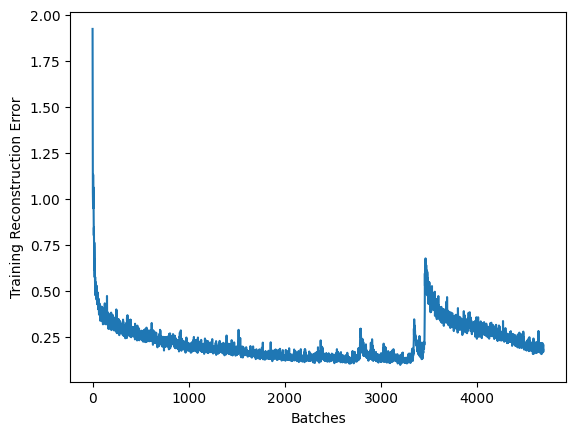

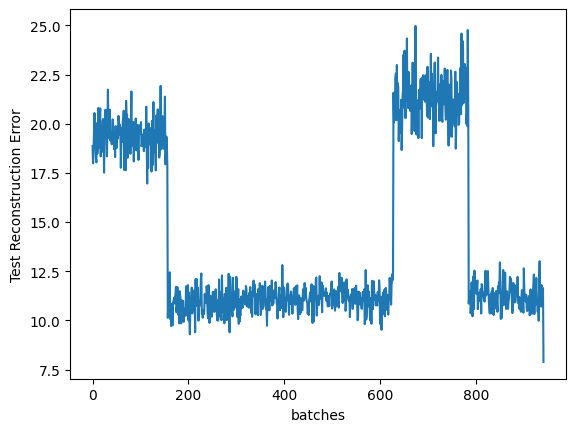

In [15]:
plt.plot(train_res_recon_error)
plt.xlabel('Batches')
plt.ylabel('Training Reconstruction Error')
plt.show()

plt.plot(test_res_recon_error)
plt.xlabel('batches')
plt.ylabel('Test Reconstruction Error')
plt.show()

## Preliminary VQ-VAE Reconstruction Results

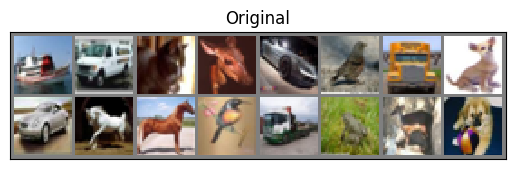

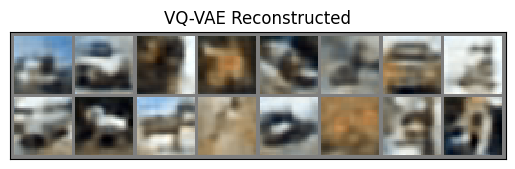

In [16]:
vqvae.eval()
temp_loader = torch.utils.data.DataLoader(validation_data,batch_size=16,shuffle=True)
(valid_originals, _) = next(iter(temp_loader))
valid_originals = valid_originals.to(device)

_, valid_recon, _ = vqvae(valid_originals)
def show(img, title):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.set_title(title)


show(torchvision.utils.make_grid(valid_originals.cpu())+0.5, "Original")
plt.show()
show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, "VQ-VAE Reconstructed")
plt.show()

##Sampling Uniformly From Latent Distribution

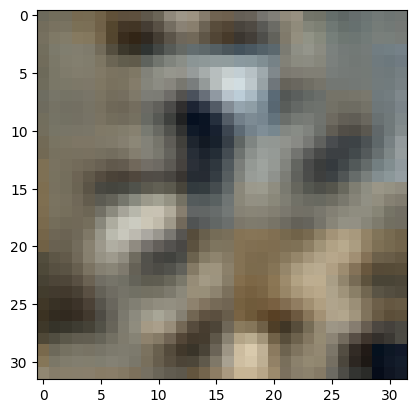

In [17]:
def sample_model(model):
    #sample 8 x 8 embedding vectors
    encoding_indices = torch.argmin(torch.rand(size = [8 * 8, n_embeddings]), dim=1).to(device).unsqueeze(1)
    encodings = torch.zeros(encoding_indices.shape[0], n_embeddings, device=device)
    encodings.scatter_(1, encoding_indices, 1)
    quantized = torch.matmul(encodings, model.vector_quantization._embedding.weight).view(1, 8, 8, 64)
    quantized = quantized.permute(0, 3, 1, 2).contiguous()
    z_e = model.decoder(quantized)
    return z_e
    
plt.imshow(sample_model(vqvae).squeeze(0).permute(1, 2, 0).cpu().detach() + 0.5)

### Concept Check 3.2.4

## Ablations & Visualizations:

### Quick AE Implementation Using Same Encoder-Decoder Architecture as VQ-VAE:

In [18]:
# AE/VAE hyperparams
batch_size = 64
n_hiddens = 64
n_residual_hiddens = 32
n_residual_layers = 2
embedding_dim = 64
code_size=8

epochs = 6
lr = 1e-3
noise=False
noise_weight=.1
lin_dim=256
regularization_weight = .0001

In [19]:
class AE(nn.Module):
    def __init__(self, h_dim, res_h_dim, n_res_layers, embedding_dim, lin_dim):
        super().__init__()

        self.h_dim = h_dim
        # encode image into continuous latent space
        self.encoder = Encoder(3, h_dim, n_res_layers, res_h_dim)

        #FC Projections
        self.fc1 = nn.Linear(h_dim*code_size*code_size, lin_dim)
        self.fc2 = nn.Linear(lin_dim, h_dim*code_size*code_size)

        # decode the discrete latent representation
        self.decoder = Decoder(embedding_dim, h_dim, n_res_layers, res_h_dim)

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(-1, self.h_dim*code_size*code_size)
        return self.fc1(x)

    def decode(self, z):
        z = self.fc2(z)
        z = z.view(-1, self.h_dim, code_size, code_size)
        return self.decoder(z)
    
    def train_step(self, optimizer, x_in, x_star):
        z = self.encode(x_in)
        x_hat = self.decode(z)

        loss = self.loss(x_star, x_hat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss
    
    def test_step(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        
        loss = self.loss(x, x_hat)
        return loss
    @staticmethod
    def loss(x, x_hat):
        #Mean-Squared Error Reconstruction Loss
        criterion = nn.MSELoss()
        return criterion(x, x_hat)

In [20]:
ae = AE(n_hiddens, n_residual_hiddens, n_residual_layers, embedding_dim, lin_dim).to(device)
optimizer = torch.optim.Adam(ae.parameters(), lr=lr)
# train
ae_train_losses = []
ae_test_losses = []
step = 0
report_every = 500
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")
    #train loss:
    for x, y in tqdm(train_loader):
        x_no_noise = x.to(device)
        if noise:
            x_in = add_noise(x_no_noise, noise_weight=noise_weight)
        else:
            x_in = x_no_noise
        loss = ae.train_step(optimizer, x_in=x_in, x_star=x_no_noise)
        ae_train_losses.append(loss.cpu().detach().numpy()) #loss every iteration
        step += 1
        if step % report_every == 0:
            print(f"Training loss: {loss}")
    #ae_train_losses.append(loss.detach().numpy()) #loss after every epoch
    #test loss
    ae.eval()
    with torch.no_grad():
      for X_test, y_test in validation_loader:
          X_test = X_test.to(device)
          loss = ae.test_step(X_test)
          ae_test_losses.append(loss.cpu().detach().numpy()) #loss every iteration
      #ae_test_losses.append(loss.detach().numpy()) #loss after every epoch

Epoch 1


 64%|██████▍   | 501/782 [00:27<00:16, 16.72it/s]

Training loss: 0.019886169582605362


100%|██████████| 782/782 [00:46<00:00, 16.76it/s]


Epoch 2


 28%|██▊       | 219/782 [00:10<00:35, 15.82it/s]

Training loss: 0.013629946857690811


 92%|█████████▏| 721/782 [00:35<00:03, 15.57it/s]

Training loss: 0.009886320680379868


100%|██████████| 782/782 [00:38<00:00, 20.08it/s]


Epoch 3


 56%|█████▌    | 437/782 [00:23<00:16, 20.45it/s]

Training loss: 0.008058901876211166


100%|██████████| 782/782 [00:40<00:00, 19.33it/s]


Epoch 4


 20%|█▉        | 156/782 [00:08<00:41, 15.26it/s]

Training loss: 0.006656227167695761


 84%|████████▍ | 656/782 [00:32<00:08, 15.26it/s]

Training loss: 0.007582441903650761


100%|██████████| 782/782 [00:39<00:00, 19.97it/s]


Epoch 5


 48%|████▊     | 374/782 [00:18<00:18, 21.60it/s]

Training loss: 0.007471354212611914


100%|██████████| 782/782 [00:39<00:00, 19.76it/s]


Epoch 6


 12%|█▏        | 93/782 [00:04<00:32, 21.48it/s]

Training loss: 0.005622386001050472


 76%|███████▌  | 593/782 [00:29<00:10, 17.84it/s]

Training loss: 0.005786772817373276


100%|██████████| 782/782 [00:39<00:00, 19.92it/s]


### Quick VAE Implementation Using Same Encoder-Decoder Architecture as VQ-VAE:

In [21]:
class VAE(nn.Module):
    def __init__(self, h_dim, res_h_dim, n_res_layers, embedding_dim):
        super().__init__()
        self.z_mean = Encoder(3, h_dim, n_res_layers, res_h_dim)
        self.z_log_std = Encoder(3, h_dim, n_res_layers, res_h_dim)
        self.decoder = Decoder(embedding_dim, h_dim, n_res_layers, res_h_dim)

        self.h_dim = h_dim
        #FC Projections
        self.fc1 = nn.Linear(h_dim*code_size*code_size, lin_dim)
        self.fc2 = nn.Linear(lin_dim, h_dim*code_size*code_size)
    
    def _encode(self, x):
        x_mean = self.z_mean(x)
        x_flat = x_mean.view(-1, self.h_dim*code_size*code_size)
        z_mean = self.fc1(x_flat)
        

        x_std = self.z_log_std(x)
        x_flat = x_std.view(-1, self.h_dim*code_size*code_size)
        z_log_std = self.fc1(x_flat)
        z_log_std = nn.Sigmoid()(z_log_std)
        # reparameterization trick
        z_std = torch.exp(z_log_std)

        eps = torch.randn_like(z_std)
        z = z_mean + eps * z_std
        # log prob
        # 'd' not sampled on purpose
        # to show reparameterization trick
        d = Independent(Normal(z_mean, z_std), 1)
        log_prob = d.log_prob(z)
        
        return z_mean + eps * z_std, log_prob
    
    def encode(self, x):
        z, _ = self._encode(x)
        return z

    def decode(self, z):
        z = self.fc2(z)
        z = z.view(-1, self.h_dim, code_size, code_size)
        return self.decoder(z)
    
    def train_step(self, optimizer, x_in, x_star):
        z, log_prob = self._encode(x_in)
        x_hat = self.decode(z)
        loss = self.loss(x_star, x_hat, z, log_prob)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss
    
    def test_step(self, x):
        z, log_prob = self._encode(x)
        x_hat = self.decode(z)
        
        loss = self.loss(x, x_hat, z, log_prob)
        return loss

    @staticmethod
    def loss(x, x_hat, z, log_prob, kl_weight=regularization_weight):
        criterion = nn.MSELoss()
        reconst_loss = criterion(x, x_hat)

        z_dim = z.shape[-1]
        standard_normal = MultivariateNormal(torch.zeros(z_dim).to(device), 
                                             torch.eye(z_dim).to(device))
        #print(MultivariateNormal.device)
        kld_loss = (log_prob - standard_normal.log_prob(z)).mean()
        
        return reconst_loss + kl_weight * kld_loss

In [22]:
vae = VAE(n_hiddens, n_residual_hiddens, n_residual_layers, embedding_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

# train
vae_train_losses = []
vae_test_losses = []
step = 0
report_every = 500
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")
    #train loss:
    for x, y in tqdm(train_loader):
        x_no_noise = x.to(device)
        if noise:
            x_in = add_noise(x_no_noise, noise_weight=noise_weight)
        else:
            x_in = x_no_noise
        loss = vae.train_step(optimizer, x_in=x_in, x_star=x_no_noise)
        vae_train_losses.append(loss.cpu().detach().numpy()) #loss every iteration
        step += 1
        if step % report_every == 0:
            print(f"Training loss: {loss}")
    #vae_train_losses.append(loss.detach().numpy()) #loss after every epoch
    #test loss
    for b, (X_test, y_test) in enumerate(validation_loader):
        X_test = X_test.to(device)
        loss = vae.test_step(X_test)
        vae_test_losses.append(loss.cpu().detach().numpy()) #loss every iteration
    #vae_test_losses.append(loss.detach().numpy()) #loss after every epoch

Epoch 1


 64%|██████▍   | 501/782 [00:43<00:22, 12.43it/s]

Training loss: 0.0381871722638607


100%|██████████| 782/782 [01:07<00:00, 11.54it/s]


Epoch 2


 28%|██▊       | 219/782 [00:18<00:47, 11.81it/s]

Training loss: 0.030748819932341576


 92%|█████████▏| 720/782 [01:01<00:04, 12.81it/s]

Training loss: 0.03227856382727623


100%|██████████| 782/782 [01:06<00:00, 11.72it/s]


Epoch 3


 56%|█████▌    | 437/782 [00:37<00:27, 12.44it/s]

Training loss: 0.032370857894420624


100%|██████████| 782/782 [01:07<00:00, 11.63it/s]


Epoch 4


 20%|█▉        | 155/782 [00:13<00:50, 12.47it/s]

Training loss: 0.028988860547542572


 84%|████████▍ | 655/782 [00:56<00:10, 12.29it/s]

Training loss: 0.02614806778728962


100%|██████████| 782/782 [01:07<00:00, 11.51it/s]


Epoch 5


 48%|████▊     | 373/782 [00:32<00:33, 12.06it/s]

Training loss: 0.26057809591293335


100%|██████████| 782/782 [01:08<00:00, 11.46it/s]


Epoch 6


 12%|█▏        | 92/782 [00:07<00:56, 12.31it/s]

Training loss: 0.0950436219573021


 76%|███████▌  | 592/782 [00:51<00:15, 12.18it/s]

Training loss: 0.08299969136714935


100%|██████████| 782/782 [01:07<00:00, 11.62it/s]


### 1. Loss Visualization (AE vs. VAE vs. VQVAE):

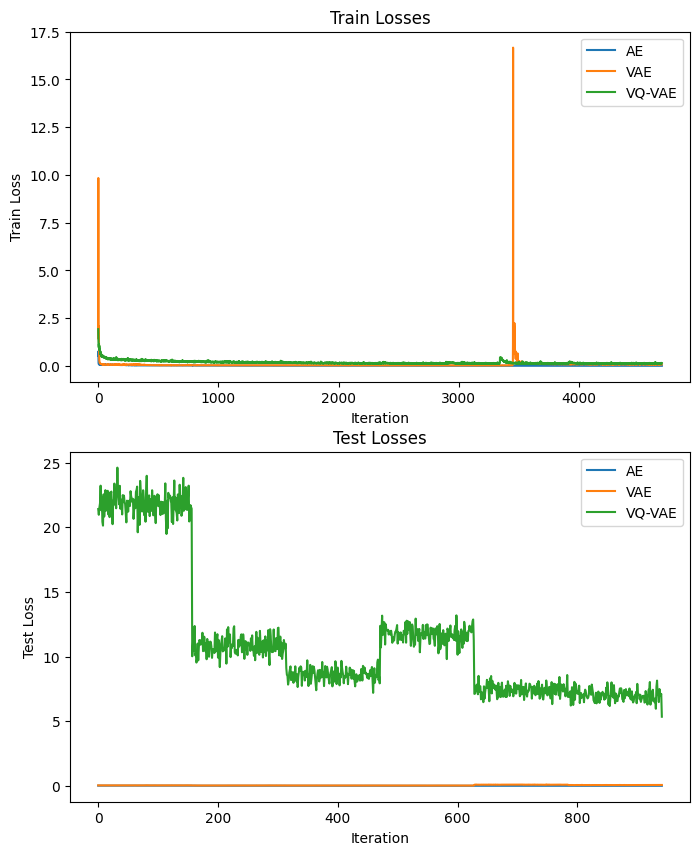

In [23]:
with torch.no_grad():
    fig, ax = plt.subplots(2, figsize=(8,10))
    ax[0].plot(ae_train_losses, label="AE")
    ax[0].plot(vae_train_losses, label="VAE")
    ax[0].plot(train_res_recon_error, label="VQ-VAE")
    ax[0].set_title("Train Losses")
    ax[0].set_ylabel("Train Loss")
    ax[0].set_xlabel("Iteration")
    ax[0].legend()
    
    ax[1].plot(ae_test_losses, label="AE")
    ax[1].plot(vae_test_losses, label="VAE")
    ax[1].plot(test_res_recon_error, label="VQ-VAE")
    ax[1].set_title("Test Losses")
    ax[1].set_ylabel("Test Loss")
    ax[1].set_xlabel("Iteration")
    ax[1].legend()

#Note: if you want per epoch (or avg. epoch) losses, you will have to change the above code somewhat

### Concept Check 3.3.1

### 2. Reconstruction Visualization (AE vs. VAE vs. VQVAE):

Labels: tensor([0, 9, 3, 7, 9, 5, 1, 9, 4, 2])


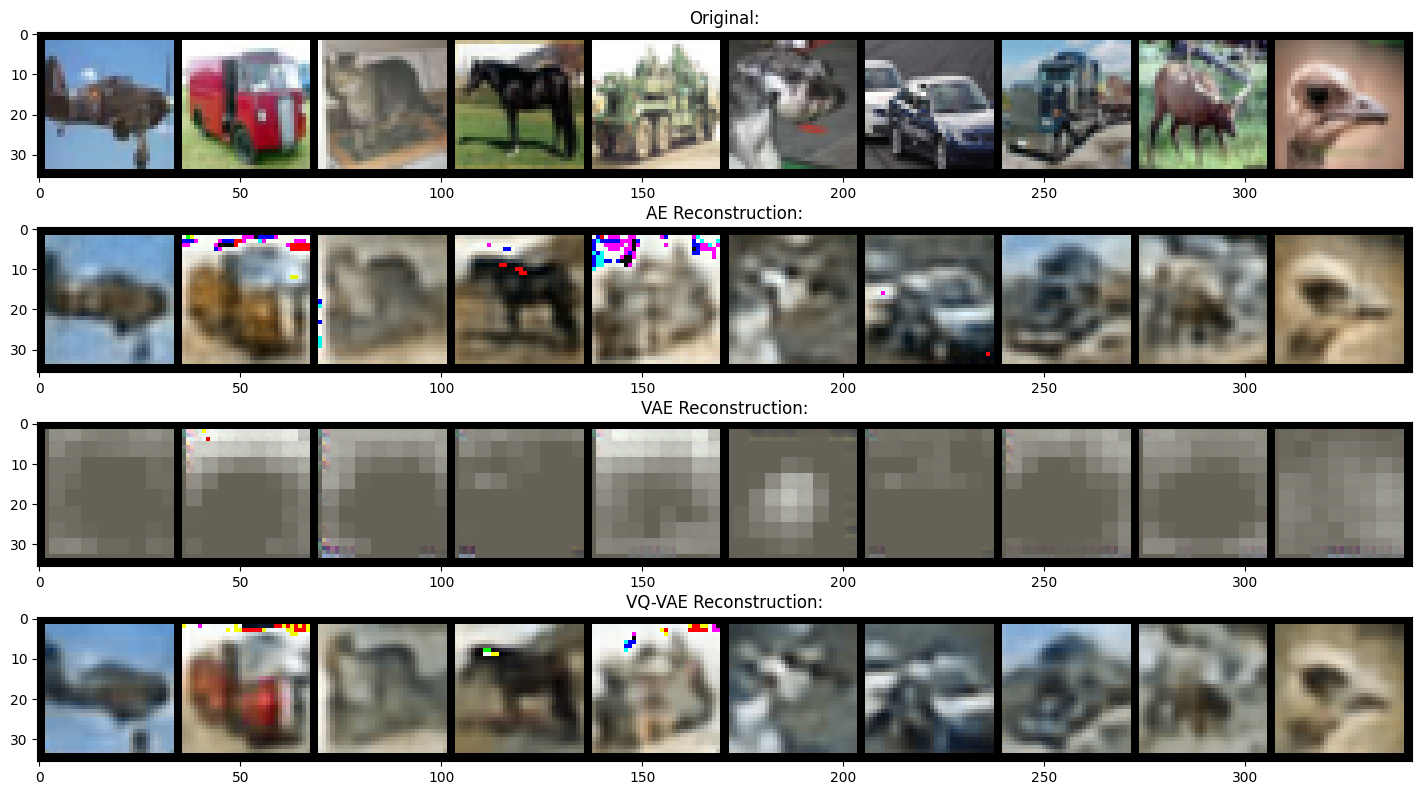

In [24]:
#Visualize the samples in bulk:
ae.eval()
vae.eval()
vqvae.eval()
with torch.no_grad():
    #Grab first batch of images:
    for images, labels in validation_loader:
        recon_ae = ae.decode(ae.encode(images.to(device)))
        recon_vae = vae.decode(vae.encode(images.to(device)))
        _, recon_vqvae, _ = vqvae(images.to(device))
        break


    #Print and show the first 10 samples:

    print(f"Labels: {labels[0:10]}")
    mean=[0.5,0.5,0.5]
    std=[1.0,1.0,1.0]
    inv_normalize = transforms.Normalize(
        mean= [-m/s for m, s in zip(mean, std)],
        std= [1/s for s in std]
    )
    im = make_grid(inv_normalize(images[0:10])*255, nrow=10)
    ae_im = make_grid(inv_normalize(recon_ae[:10])*255, nrow=10)
    vae_im = make_grid(inv_normalize(recon_vae[:10])*255, nrow=10)
    vqvae_im = make_grid(inv_normalize(recon_vqvae[:10])*255, nrow=10)

    fig, ax = plt.subplots(4, figsize=(80,8))
    fig.tight_layout(pad=1.5)
    ax[0].imshow(np.transpose(im.numpy(), (1, 2, 0)).astype('uint8')) #Remember that default MNIST data is CWH, but matplotlib uses WHC
    ax[0].set_title("Original:")

    ax[1].imshow(np.transpose(ae_im.cpu().numpy(), (1, 2, 0)).astype('uint8'))
    ax[1].set_title("AE Reconstruction:")
    
    ax[2].imshow(np.transpose(vae_im.cpu().numpy(), (1, 2, 0)).astype('uint8'))
    ax[2].set_title("VAE Reconstruction:")

    ax[3].imshow(np.transpose(vqvae_im.cpu().numpy(), (1, 2, 0)).astype('uint8'))
    ax[3].set_title("VQ-VAE Reconstruction:")

### Concept Check 3.3.2

### 3. Denoising Ablation:

Now, let us see the denoising capabilities of these architectures. Go back to the function add_noise in order to add some Gaussian noise to the training data, $X$. You can just copy-paste this from the AE-VAE notebook and **set the noise hyperparameter to True**. Then, apply this noise to the sample when training.

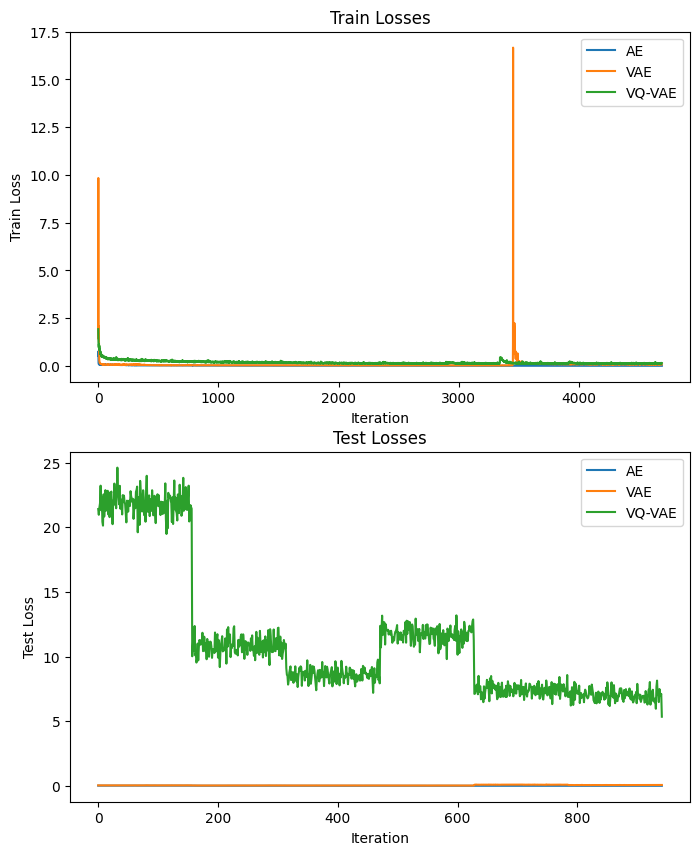

In [25]:
with torch.no_grad():
    fig, ax = plt.subplots(2, figsize=(8,10))
    ax[0].plot(ae_train_losses, label="AE")
    ax[0].plot(vae_train_losses, label="VAE")
    ax[0].plot(train_res_recon_error, label="VQ-VAE")
    ax[0].set_title("Train Losses")
    ax[0].set_ylabel("Train Loss")
    ax[0].set_xlabel("Iteration")
    ax[0].legend()
    
    ax[1].plot(ae_test_losses, label="AE")
    ax[1].plot(vae_test_losses, label="VAE")
    ax[1].plot(test_res_recon_error, label="VQ-VAE")
    ax[1].set_title("Test Losses")
    ax[1].set_ylabel("Test Loss")
    ax[1].set_xlabel("Iteration")
    ax[1].legend()

#Note: if you want per epoch (or avg. epoch) losses, you will have to change the above code somewhat

Labels: tensor([7, 1, 2, 6, 3, 1, 7, 8, 4, 5])


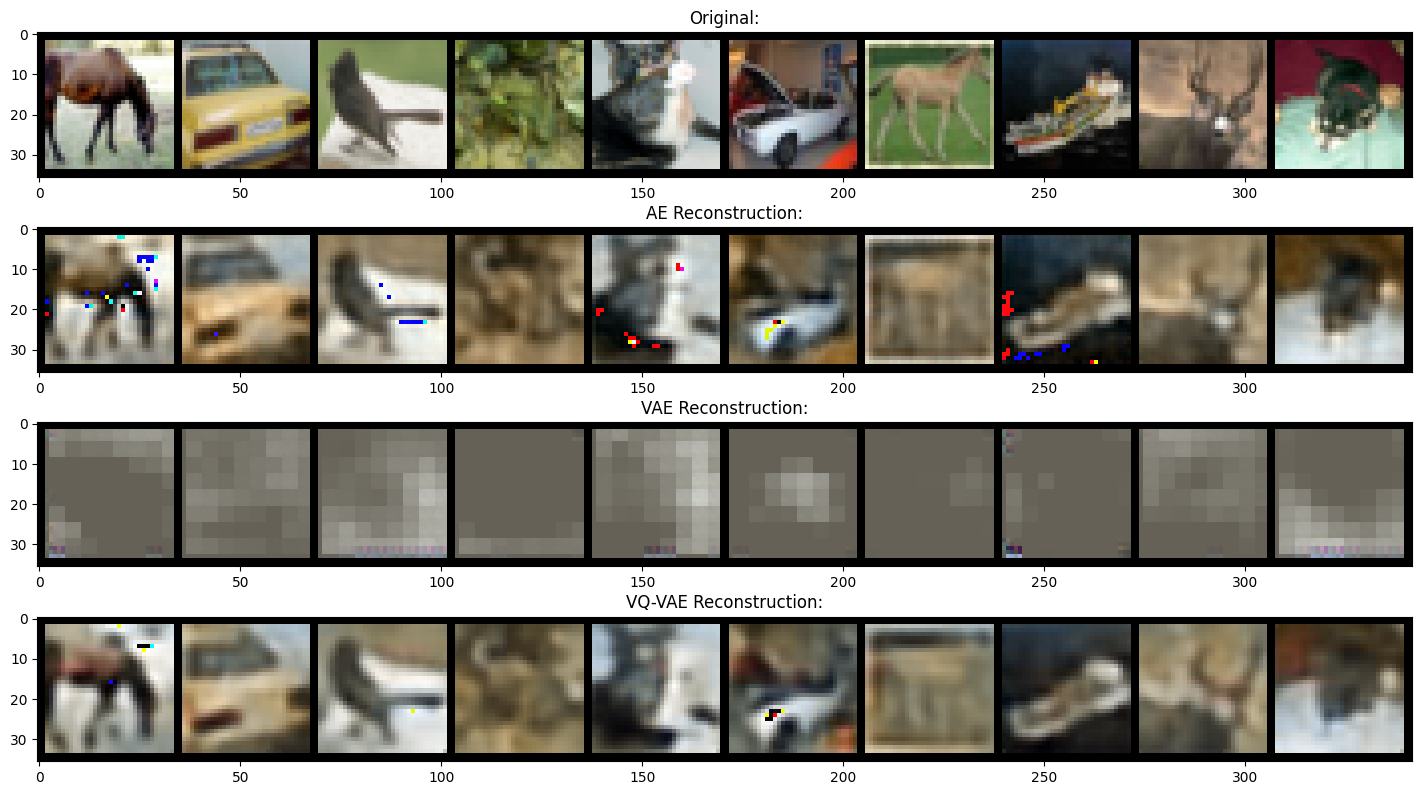

In [26]:
#Visualize the samples in bulk:
ae.eval()
vae.eval()
vqvae.eval()
with torch.no_grad():
    #Grab first batch of images:
    for images, labels in validation_loader:
        recon_ae = ae.decode(ae.encode(images.to(device)))
        recon_vae = vae.decode(vae.encode(images.to(device)))
        _, recon_vqvae, _ = vqvae(images.to(device))
        break


    #Print and show the first 10 samples:

    print(f"Labels: {labels[0:10]}")
    mean=[0.5,0.5,0.5]
    std=[1.0,1.0,1.0]
    inv_normalize = transforms.Normalize(
        mean= [-m/s for m, s in zip(mean, std)],
        std= [1/s for s in std]
    )
    im = make_grid(inv_normalize(images[0:10])*255, nrow=10)
    ae_im = make_grid(inv_normalize(recon_ae[:10])*255, nrow=10)
    vae_im = make_grid(inv_normalize(recon_vae[:10])*255, nrow=10)
    vqvae_im = make_grid(inv_normalize(recon_vqvae[:10])*255, nrow=10)

    fig, ax = plt.subplots(4, figsize=(80,8))
    fig.tight_layout(pad=1.5)
    ax[0].imshow(np.transpose(im.numpy(), (1, 2, 0)).astype('uint8')) #Remember that default MNIST data is CWH, but matplotlib uses WHC
    ax[0].set_title("Original:")

    ax[1].imshow(np.transpose(ae_im.cpu().numpy(), (1, 2, 0)).astype('uint8'))
    ax[1].set_title("AE Reconstruction:")
    
    ax[2].imshow(np.transpose(vae_im.cpu().numpy(), (1, 2, 0)).astype('uint8'))
    ax[2].set_title("VAE Reconstruction:")

    ax[3].imshow(np.transpose(vqvae_im.cpu().numpy(), (1, 2, 0)).astype('uint8'))
    ax[3].set_title("VQ-VAE Reconstruction:")

### 4. Sample Generation Ablation:

**Sampling**

Unlike VAEs, VQ-VAEs can be difficult to sample from. Recall in VAEs, we enforced $p(z) \sim N(0, I)$ using a KL divergence loss. This makes it easy to sample a VAE. But VQ-VAEs don't have this nice property. 

To see this, we can try sampling $z$ uniformly, and see the resulting image. To be more explicit, for each latent pixel in the 8x8 space, we sample one of the 512 codebook vectors uniformly, then feed the whole thing into the decoder.

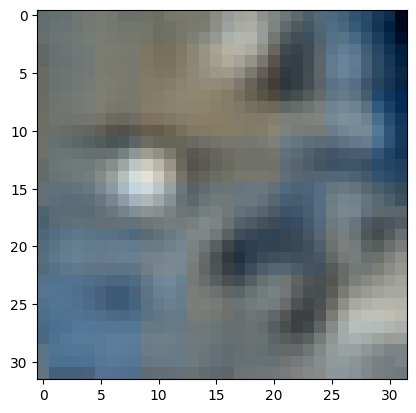

In [18]:
# reusing the code from earlier
plt.imshow(sample_model(vqvae).squeeze(0).permute(1, 2, 0).cpu().detach() + 0.5)

Chances are the generated image is difficult to recognize. We have 512 codebook vectors, each of which can go into 1 of the squares in the 8 by 8 embedding. So despite being a discrete representation, there are some $64^{512} \approx 10^{900}$ possible things that can be encoded. So it makes sense that sampling uniformly in this space likely won't reveal anything meaningful. 

Run the code below to see an example of the embedding index per latent pixel. Do this a couple times for different images. What do you see, are there patterns you notice?

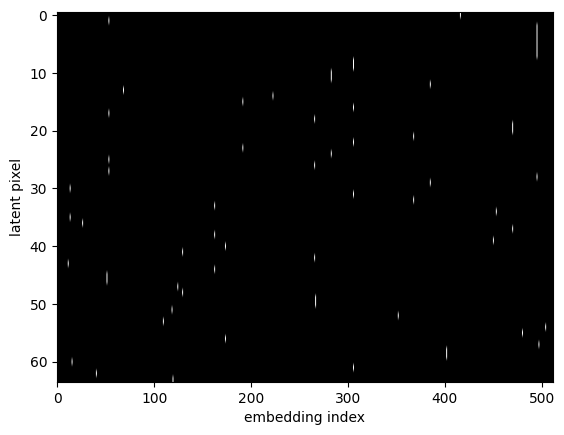

In [19]:
# vqvae latents
viz_loader = torch.utils.data.DataLoader(training_data, batch_size = 1, shuffle = True)
X, _ = next(iter(viz_loader))
X = X.to(device)
z_e = vqvae.encoder(X)
z_e = vqvae.pre_quantization_conv(z_e)
_, z_q, _, encodings = vqvae.vector_quantization(z_e)
plt.imshow(encodings.cpu().numpy(), cmap='gray', aspect='auto')
plt.xlabel('embedding index')
plt.ylabel('latent pixel')
plt.show()

**Train an autoregressive model**

From the visualizations above, it should be relatively clear that the embeddings chosen per pixel are neither uniformly distributed, nor independent. We'd been breaking apart $p(z_1,\ldots, z_n) = \prod_{i=1}^n p(z_i)$. What would make the generation better would be to learn a conditional distribution of each latent pixel based on the previous ones: $p(z_k | z_{k-1} \ldots z_1)$. In the original VQ-VAE paper, this is done using an autoregressive model, PixelCNN. Here, we attempt to do the same thing.

In [20]:
# PixelCNNs aren't the focus of this project.
# This was taken from: https://github.com/jzbontar/pixelcnn-pytorch/

class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        assert mask_type in {'A', 'B'}
        self.register_buffer('mask', self.weight.data.clone())
        _, _, kH, kW = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, kH // 2, kW // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, kH // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

fm = 64
pixCNN = nn.Sequential(
    MaskedConv2d('A', 512,  fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    nn.Conv2d(fm, 512, 1)).to(device)

In [21]:
lr = 0.001
batch_size = 128
epochs = 10

optimizer = torch.optim.Adam(pixCNN.parameters(), lr=lr)
train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)

train_losses = []
for _ in range(epochs):
    for X, _ in tqdm(train_loader):
        if X.shape[0] != batch_size:
            continue

        # get our embedding
        X = X.to(device)
        z_e = vqvae.encoder(X)
        z_e = vqvae.pre_quantization_conv(z_e)
        _, z_q, _, encodings = vqvae.vector_quantization(z_e) 

        enc_inds = encodings.argmax(dim=1, keepdims=True)
        encodings_img = encodings.reshape(batch_size, 8, 8, -1)
        encodings_img = encodings_img.permute(0, 3, 1, 2).float().to(device)

        # learn
        optimizer.zero_grad()
        output = pixCNN(encodings_img)

        output = output.permute(0, 2, 3, 1)
        output = output.reshape(-1, 512)

        loss = F.cross_entropy(output, enc_inds.squeeze(1).long())
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
    print(train_losses[-1])

100%|██████████| 391/391 [00:31<00:00, 12.26it/s]


2.805420160293579


100%|██████████| 391/391 [00:32<00:00, 12.15it/s]


2.5375020503997803


100%|██████████| 391/391 [00:31<00:00, 12.53it/s]


2.375437021255493


100%|██████████| 391/391 [00:31<00:00, 12.54it/s]


2.402897834777832


100%|██████████| 391/391 [00:31<00:00, 12.41it/s]


2.3562839031219482


100%|██████████| 391/391 [00:30<00:00, 12.62it/s]


2.339416027069092


100%|██████████| 391/391 [00:31<00:00, 12.42it/s]


2.2428157329559326


100%|██████████| 391/391 [00:31<00:00, 12.55it/s]


2.276747465133667


100%|██████████| 391/391 [00:31<00:00, 12.44it/s]


2.316887378692627


100%|██████████| 391/391 [00:31<00:00, 12.55it/s]

2.282939910888672


In [22]:
torch.save(pixCNN.state_dict(), 'PixCNN.pt')
pixCNN.load_state_dict(torch.load('PixCNN.pt'))

<All keys matched successfully>

<ipython-input-27-f24f0624d995>:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = F.softmax(output[:, :, i, j])


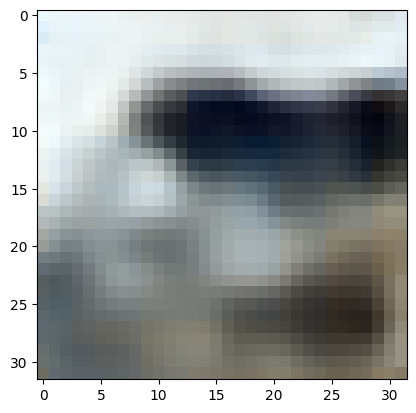

In [27]:
sample = torch.zeros(1, 512, 8, 8).to(device)
for i in range(8):
    for j in range(8):
        output = pixCNN(sample)
        weights = F.softmax(output[:, :, i, j])
        embed_indx = torch.multinomial(weights, 1).item()
        sample[:, embed_indx, i, j] = 1

sample = sample.squeeze(0).reshape(512, 64)
sample = sample.permute((1, 0))

quantized = torch.matmul(sample, vqvae.vector_quantization._embedding.weight)
quantized = quantized.view(1, 8, 8, 64)
quantized = quantized.permute(0, 3, 1, 2).contiguous()
z_e = vqvae.decoder(quantized)

plt.imshow(z_e.squeeze(0).permute(1, 2, 0).cpu().detach() + 0.5)
plt.show()

## **[Important]** Bringing it All Together:



From your exploration of the different ablations, you should now be able to trace the developmental ideas that inform autoencoder architectures. We started with the AE, which is method for dimensionality reduction that is motivated by the simple idea that the latent representation of some data will probably be informative if it can be reconstructed to yield the original input data. However, there were some clear limitations. (1) The latent space wasn't organized in any meaningful way. (2) A lack of any regularization of the latent code prevents AE from doing better in denoising. (3) The first two problems prevent the AE from being effective in sample generation. 


These issues are fixed in the AE by modeling the latent space as being sampled from a Gaussian. We usually find worse reconstruction thanks to this regularization, but we gain richer capabilities in denoising and sample generation.


The final improvement we explored comes from the VQ-VAE, which replaces the continuous Gaussian in the VAE with a discrete distribution of latent codes. This is helpful (1) for preventing posterior collapse, but more importantly (2), most data types are a composition of *discrete elements*. Thus, we find the VQ-VAE is an improvement over the VAE in nearly all ways.

## Where to Go Next:

Congratulations! You have finished all our demos, ablations, and conceptual questions on AEs, VAEs, and VQ-VAEs. This is a very solid foundation for utilizing autoencoder models and the subfield of representation learning in general. From here on, nearly all research areas and model architectures will be somewhat based on those that you've seen. Here are some ideas for what to explore next:




1.   [CVAE](https://papers.nips.cc/paper_files/paper/2015/hash/8d55a249e6baa5c06772297520da2051-Abstract.html): Conditional VAEs are the next step following VAEs. The formulation allows for a more deterministic method for generating samples.
2.   [RQVAE](http://arxiv.org/abs/2203.01941): The next stage of progress in extending the capabilities of the VQ-VAE.
3.   [MISA](http://arxiv.org/abs/2005.03545): A fascinating use of AE architectures for multi-modal sentiment analysis.
4.   [GANs](http://arxiv.org/abs/1406.2661): Generative Adversarial Networks (GANs) are somewhat similar in motivation to AE architectures. At a very high-level, it's much like an "inverted" AE that has the sole purpose of data generation and data discrimination.
5.   Anomaly Detection: AE and GAN-like architectures being used in this subfield of research is very common.
  - https://doi.org/10.1186/s42400-022-00134-9
  - http://arxiv.org/abs/1511.05644
  - http://arxiv.org/abs/2003.10713




## References

Any references utilized in this project can be found in the README of our repo